In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pyecharts.charts as pyc
import pyecharts.options as opts
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']   # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False     # 用来正常显示负号
matplotlib.rc("font",family='Heiti TC')
# 作图的字体默认设置
fontdict = {'fontsize': 15,'horizontalalignment': 'center'}

## 数据准备

### 导入数据

In [2]:
baby = pd.read_csv("sam_tianchi_mum_baby.csv")
trade = pd.read_csv("sam_tianchi_mum_baby_trade_history.csv")

In [3]:
baby.head()

,user_id,birthday,gender
0,2757,20130311,1
1,415971,20121111,0
2,1372572,20120130,1
3,10339332,20110910,0
4,10642245,20130213,0


In [4]:
trade.head()

,user_id,auction_id,cat_id,cat1,property,buy_mount,day
0,786295544,41098319944,50014866,50022520,21458:86755362;13023209:3593274;10984217:21985...,2,20140919
1,532110457,17916191097,50011993,28,21458:11399317;1628862:3251296;21475:137325;16...,1,20131011
2,249013725,21896936223,50012461,50014815,21458:30992;1628665:92012;1628665:3233938;1628...,1,20131011
3,917056007,12515996043,50018831,50014815,21458:15841995;21956:3494076;27000458:59723383...,2,20141023
4,444069173,20487688075,50013636,50008168,21458:30992;13658074:3323064;1628665:3233941;1...,1,20141103


In [5]:
baby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   953 non-null    int64
 1   birthday  953 non-null    int64
 2   gender    953 non-null    int64
dtypes: int64(3)
memory usage: 22.5 KB


In [6]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29971 entries, 0 to 29970
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     29971 non-null  int64 
 1   auction_id  29971 non-null  int64 
 2   cat_id      29971 non-null  int64 
 3   cat1        29971 non-null  int64 
 4   property    29827 non-null  object
 5   buy_mount   29971 non-null  int64 
 6   day         29971 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.6+ MB


In [7]:
trade.buy_mount.describe()

count    29971.000000
mean         2.544126
std         63.986879
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      10000.000000
Name: buy_mount, dtype: float64

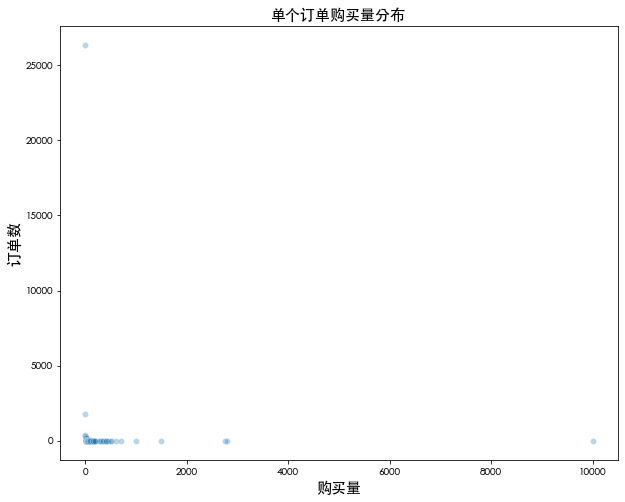

In [8]:
quantity = trade.buy_mount.value_counts().sort_index()
plt.figure(figsize=(10, 8))
sns.scatterplot(x=quantity.index, y=quantity.values, alpha=0.3)
plt.title("单个订单购买量分布", fontdict=fontdict)
plt.ylabel("订单数", fontdict=fontdict)
plt.xlabel("购买量", fontdict=fontdict)
plt.show()

### 数据清洗
1. 保留buy_amount[1,1000]以内的订单。
2. 查看有无缺失值异常值，并进行处理。
3. trade中的auction_id未指定是什么属性，我们就将他默认改为item_id。
4. 数据集中的property全是数字，需要有对应的字典才能知道对应什么属性，这边先删除。
5. day改成日期形式。

In [9]:
# 保留buy_mount[0,1000]以内的记录
trade = trade[(trade.buy_mount >= 1) & (trade.buy_mount <= 1000)]
# 列重命名
trade.rename({"auction_id": "item_id"}, axis=1, inplace=True)
# 先将property暂且取出放在一边，后续再分析
property = trade.property
trade.drop('property', axis=1, inplace=True)
# 日期类型转换
baby['birthday'] = pd.to_datetime(baby.birthday.astype('str'))
trade['day'] = pd.to_datetime(trade.day.astype('str'))

In [10]:
# 本次统计数据的时间范围是2012/7/2-2015/2/5
trade.day.describe()

count                   29967
unique                    949
top       2014-11-11 00:00:00
freq                      454
first     2012-07-02 00:00:00
last      2015-02-05 00:00:00
Name: day, dtype: object

In [11]:
count_cat1 = trade.cat1.nunique()
count_cat = trade.cat_id.nunique()
count_item = trade.item_id.nunique()
sales_volume = trade.buy_mount.sum()
count_user = trade.user_id.nunique()
print("商品类目数：", count_cat1)
print("商品类别数：", count_cat)
print("商品数：", count_item)
print("总销量：", sales_volume)
print("用户数", count_user)

商品类目数： 6
商品类别数： 662
商品数： 28418
总销量： 59202
用户数 29940


## 数据分析

### 婴儿信息分析

In [12]:
baby['gender'].value_counts()

0    489
1    438
2     26
Name: gender, dtype: int64

In [13]:
baby = baby.loc[~(baby['gender'] == 2)]
baby['gender'].value_counts()

0    489
1    438
Name: gender, dtype: int64

In [14]:
male_to_female_series = baby['gender'].value_counts()
male_to_female_series[0] / male_to_female_series[1]  # 1.1164383561643836

1.1164383561643836

### 汇总购买历史数据和婴儿信息数据

In [15]:
trade = pd.merge(trade, baby, on='user_id', how='outer') 

In [16]:
trade.head()

,user_id,item_id,cat_id,cat1,buy_mount,day,birthday,gender
0,786295544,41098319944,50014866,50022520,2,2014-09-19,NaT,NaN
1,532110457,17916191097,50011993,28,1,2013-10-11,NaT,NaN
2,249013725,21896936223,50012461,50014815,1,2013-10-11,NaT,NaN
3,917056007,12515996043,50018831,50014815,2,2014-10-23,NaT,NaN
4,444069173,20487688075,50013636,50008168,1,2014-11-03,NaT,NaN


In [17]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29967 entries, 0 to 29966
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    29967 non-null  int64         
 1   item_id    29967 non-null  int64         
 2   cat_id     29967 non-null  int64         
 3   cat1       29967 non-null  int64         
 4   buy_mount  29967 non-null  int64         
 5   day        29967 non-null  datetime64[ns]
 6   birthday   930 non-null    datetime64[ns]
 7   gender     930 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int64(5)
memory usage: 2.1 MB


### 根据时间对比分析，了解整体市场情况

In [18]:
# 根据年月查看销量趋势
# 根据年分组
year_item = trade[['item_id', 'buy_mount', 'day']].groupby(by=trade.day.dt.year)[
    'buy_mount'].sum()
# 各年季度销量情况
year_quarter_item = trade[['item_id', 'buy_mount', 'day']].groupby(by=[trade.day.dt.year, trade.day.dt.quarter])[
    'buy_mount'].sum()
# 根据年月分组
year_month_item = trade[['item_id', 'buy_mount', 'day']].groupby(
    by=[trade.day.dt.year, trade.day.dt.month])['buy_mount'].sum()

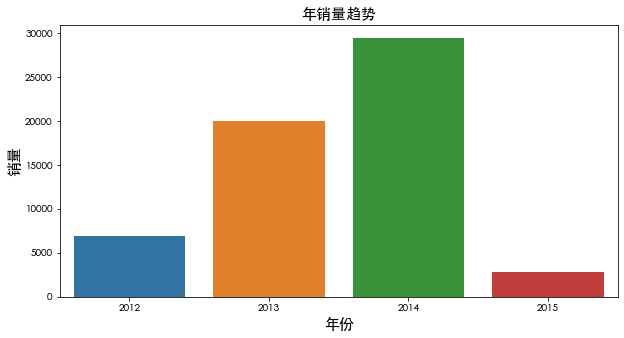

In [19]:
# 各年销量情况
plt.figure(figsize=(10, 5))
sns.barplot(x=year_item.index, y=year_item.values)
plt.title("年销量趋势", fontdict=fontdict)
plt.xlabel("年份", fontdict=fontdict)
plt.ylabel("销量", fontdict=fontdict)
plt.show()

In [20]:
trade['buy_mount'].sum()

59202

    2012/7-2015/2期间总销量是59202件，从上图我们可以看出淘宝和天猫平台母婴商品市场销量整体呈现上升趋势，但是波动较大。

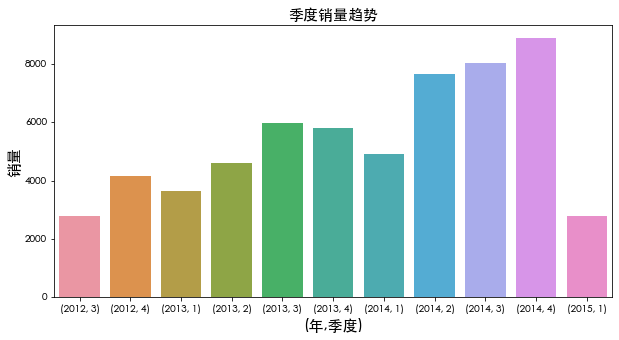

In [21]:
# 各季度销售情况
plt.figure(figsize=(10, 5))
sns.barplot(x=year_quarter_item.index.values, y=year_quarter_item.values)
plt.title("季度销量趋势", fontdict=fontdict)
plt.xlabel("(年,季度)", fontdict=fontdict)
plt.ylabel("销量", fontdict=fontdict)
plt.show()

1. 2015年由于数据缺失，所以不能反应2015年第一季度的真实销量情况
2. 每年第一季度的销售额都会呈现一定幅度的下跌。每年第四季度的销量都会呈现大幅度上升。

### 时间维度对比分析

In [22]:
# 各月份销量情况
x = [str(x[0])+"/"+str(x[1]) for x in year_month_item.index.values]
y = [int(x) for x in year_month_item.values]
pyc.Bar().add_xaxis(xaxis_data=x).add_yaxis(series_name="销量", y_axis=y, 
                                            markpoint_opts=opts.MarkPointOpts(data=[
                                                opts.MarkPointItem(coord=[x[4], y[4]], value=y[4]), 
                                                opts.MarkPointItem(coord=[x[10], y[10]], value=y[10]), 
                                                opts.MarkPointItem(coord=[x[16], y[16]], value=y[16]), 
                                                opts.MarkPointItem(coord=[x[22], y[22]], value=y[22]), 
                                                opts.MarkPointItem(coord=[x[28], y[28]], value=y[28])]
                            )).set_series_opts(
                                        label_opts=opts.LabelOpts(is_show=False)
                            ).set_global_opts(title_opts=opts.TitleOpts(title="月销量趋势", subtitle="2012/7-2015/2的销量趋势图"), toolbox_opts=opts.ToolboxOpts()).render_notebook()

1. 2013年和2014年的第一季度销量都有所下滑，主要聚集在1、2月。
2. 每年的5月、11月都会出现不同程度的销量上涨。

### 针对性分析
- 从上图可以看出，2012年至2014年的5月和11月都出现高峰凸起，整体呈现上涨趋势。

In [23]:
trade['month'] = trade['day'].astype('datetime64[M]')
trade['day_num'] = trade['day'].dt.day

Text(0.5, 1.0, 'Sales per day')

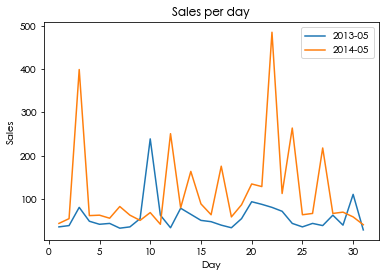

In [24]:
# 5月
# 2012年没有5月的数据
sales13_05_series = trade.query('month == "2013-05-01"')
sales14_05_series = trade.query('month == "2014-05-01"')

sales13_05_sum_series = sales13_05_series.groupby(by='day_num')['buy_mount'].sum()
sales14_05_sum_series = sales14_05_series.groupby(by='day_num')['buy_mount'].sum()

plt.plot(sales13_05_sum_series, label='2013-05')
plt.plot(sales14_05_sum_series, label='2014-05')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales per day')

Text(0.5, 1.0, 'Sales per day')

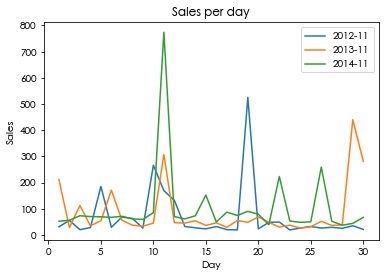

In [25]:
# 11月
sales12_11_series = trade.query('month == "2012-11-01"')
sales13_11_series = trade.query('month == "2013-11-01"')
sales14_11_series = trade.query('month == "2014-11-01"')

sales12_11_sum_series = sales12_11_series.groupby(by='day_num')['buy_mount'].sum()
sales13_11_sum_series = sales13_11_series.groupby(by='day_num')['buy_mount'].sum()
sales14_11_sum_series = sales14_11_series.groupby(by='day_num')['buy_mount'].sum()

plt.plot(sales12_11_sum_series, label='2012-11')
plt.plot(sales13_11_sum_series, label='2013-11')
plt.plot(sales14_11_sum_series, label='2014-11')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales per day')

### 复购率分析

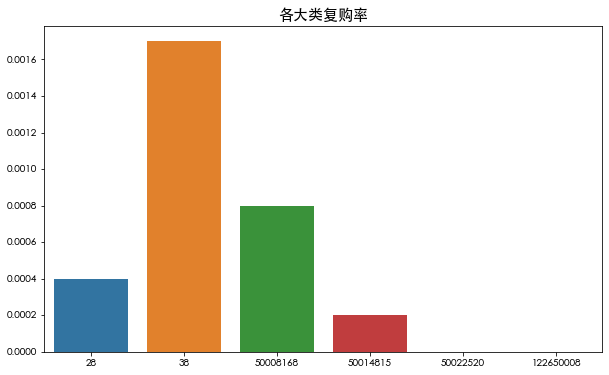

In [26]:
# 产品大类复购率
# 根据产品大类分组，然后循环大类进行索引求出每个大类的复购率
t = trade.groupby(by=['cat1', 'user_id']).size()
purchase_dict={}
for i in trade.cat1.unique():
    c = t.loc[i].value_counts()
    purchase_dict[i]=((c.sum()-c[:1])/c[:1]).values[0].round(4)
plt.figure(figsize=(10,6))
sns.barplot(x=list(purchase_dict.keys()),y=list(purchase_dict.values()))
plt.title("各大类复购率",fontdict=fontdict)
plt.show()

各产品大类的复购率也极低，均未到达1%，考虑到用户单次购买量大多是一件，且复购率低，说明用户对单一商品的回购欲望极低，商家应该从产品角度进行考虑，例如产品质量及购物体验等。

### 商品销售情况

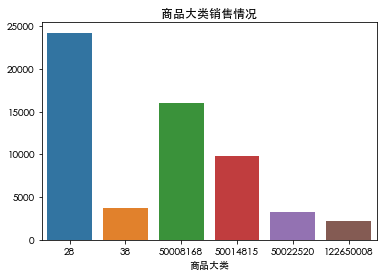

In [27]:
# 商品大类销售情况
cat = trade.groupby("cat1")['buy_mount'].sum()
sns.barplot(x=cat.index, y=cat.values)
plt.title("商品大类销售情况")
plt.xlabel("商品大类")
plt.show()

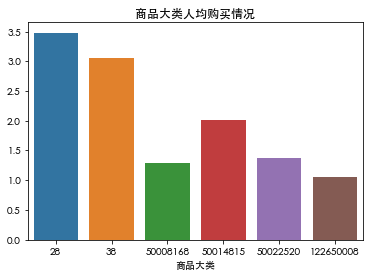

In [28]:
# 人均大类购买情况
cat_aver_user = (trade.groupby("cat1")['buy_mount'].sum(
) / trade.groupby("cat1")['user_id'].count()).sort_values(ascending=False)
sns.barplot(x=cat_aver_user.index, y=cat_aver_user.values)
plt.title("商品大类人均购买情况")
plt.xlabel("商品大类")
plt.show()

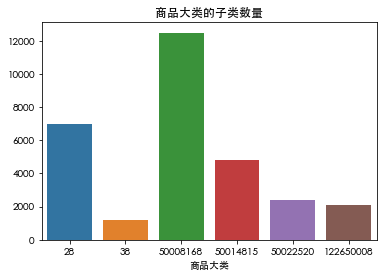

In [29]:
# 大类下子类别数量
cat_count = trade.groupby("cat1")['cat_id'].count()
sns.barplot(x=cat_count.index, y=cat_count.values)
plt.title("商品大类的子类数量")
plt.xlabel("商品大类")
plt.show()

大类28和50008168销量最佳，大类38虽然销量低、子类数最少但是人均购买量却很高，说明用户在购买38大类下的产品时选择余地较少，但同时用户对此类产品的需求又很旺盛，可以适量的增加38大类下的子类产品，提高销售量

### 项目总结

- 每年的五月和十一月都是销量高峰期，可见购物节的促销活动效果明显，应继续保持；
- 由用户总数和销售总额的上升趋势都在反映店铺对市场的影响力正逐步扩大，仍有需要开拓的市场空间，但速度在放缓；
- 因婴儿产品的特殊性，用户的生命周期有限，所以店铺的经营重心既要放在提高复购率上，同时也不能忽略新用户的获取上；